In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from bayes3d._mkl.table_scene_model import *
from bayes3d._mkl.utils import *
import matplotlib.pyplot as plt

In [3]:
import jax
from jax import jit, vmap
import jax.numpy as jnp
import os
import bayes3d as b3d
import trimesh

key = jax.random.PRNGKey(0)

In [4]:
import genjax

## Renderer and meshes

In [5]:
_scaling  = 1e-3
model_dir = os.path.join(b3d.utils.get_assets_dir(),"bop/ycbv/models")

meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    mesh = trimesh.load(mesh_path)
    mesh.vertices *= _scaling 
    meshes.append(mesh)


# Add invisible atomic table
mesh_path = os.path.join(b3d.utils.get_assets_dir(), "sample_objs/cube.obj")
mesh = trimesh.load(mesh_path)
mesh.vertices *= 1e-9
meshes.append(mesh)


In [6]:
w = 200
h = 200
f = 300
intr = b3d.Intrinsics(
    width = w, height = h,
    fx = f, fy = f,
    cx = w/2 - 0.5, cy = h/2 - 0.5,
    near = 1e-4, far = 5.0
)
b3d.setup_renderer(intr)
for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (224, 224, 1024)


In [7]:
def prep_im(Y, far=5.0, eps=1e-6):
    im = jnp.where(Y[:,:,2]>= far - eps, jnp.inf, Y[:,:,2])
    return im

In [8]:
table = jnp.eye(4)
cam   = b3d.transform_from_pos_target_up(
            jnp.array([0.0, -.5, -.75]), 
            jnp.zeros(3), 
            jnp.array([0.0,-1.0,0.0]))


scene_ch = genjax.choice_map({
        "parent_0": -1,
        "parent_1":  0,
        "parent_2":  0,
        "camera_pose": cam,
        "root_pose_0": table,
        "id_0": jnp.int32(21), # Atomic Table
        "id_1": jnp.int32(13), # Mug
        "id_2": jnp.int32(2),  # Box
        "face_parent_1": 1,  # That's the top face of the table
        "face_parent_2": 1,  # ...
        "face_child_1": 3,   # That's a bottom face of the mug
        "face_child_2": 3,
})

scene_model_args = (
    jnp.arange(3),
    jnp.arange(22),
    jnp.array([-jnp.ones(3)*100.0, jnp.ones(3)*100.0]),
    jnp.array([jnp.array([-0.2, -0.2, -2*jnp.pi]), jnp.array([0.2, 0.2, 2*jnp.pi])])
)

In [ ]:
key = keysplit(key)

(200, 200, 4)


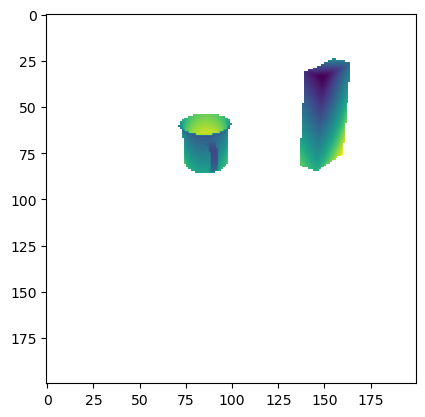

In [9]:
scene_model = make_table_scene_model()
args = (*scene_model_args, b3d.RENDERER.model_box_dims)

w, tr = scene_model.importance(key, scene_ch , args)
cam, ps, inds = tr.retval
# X = b3d.RENDERER.render(inv(cam) @ ps , inds)
X = b3d.RENDERER.render_many_custom_intrinsics(inv(cam) @ ps[None] , inds, b3d.RENDERER.intrinsics)[0]

scene_ch = tr.strip()

print(X.shape)
# =====================
plt.imshow(prep_im(X))

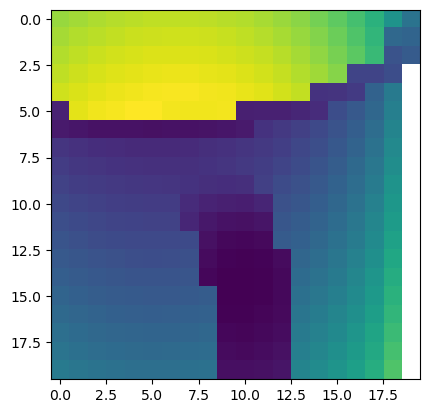

In [27]:

att_w = 20
att_h = 20
att = jnp.array([90,70])

# =====================
# plt.imshow(prep_im(X))
# plt.scatter(att[0],att[1])
# plt.scatter(att[0] + att_w,att[1]+att_h)
plt.imshow(prep_im(X[att[1]- att_h//2:att[1] + att_h//2, att[0]- att_w//2:att[0] + att_w//2]))


In [23]:
from genjax import tfp_uniform as uniform


def make_patch_model(meshes, intrinsics, w, h, scene_model_args):

    
    b3d.setup_renderer(intrinsics)
    for mesh in meshes: b3d.RENDERER.add_mesh(mesh, center_mesh=True)
    
    scene_model = make_table_scene_model()


    @genjax.gen
    def patch_model():

        cam, ps, inds = scene_model(*scene_model_args, b3d.RENDERER.model_box_dims) @ "scene"
        center        = uniform(jnp.array([0.0,0.0]), jnp.array([w, h], dtype=jnp.float32)) @ "center"

        intr = b3d.Intrinsics(
            width = intrinsics.width, height = intrinsics.height,
            fx    = intrinsics.fx,    fy     = intrinsics.fy,
            cx    = w/2 - 0.5 + intrinsics.width/2 - center[0],  cy = h/2 - 0.5  + intrinsics.height/2 - center[1],
            near = intrinsics.near, 
            far  = intrinsics.far
        )

        Y = b3d.RENDERER.render_many_custom_intrinsics(inv(cam) @ ps[None] , inds, intr)[0]

        return Y

    return patch_model


In [24]:
w = 20
h = 20
f = 300
intrinsics = b3d.Intrinsics(
    width = w, height = h,
    fx = f, fy = f,
    cx = w/2 - 0.5, cy = h/2 - 0.5,
    near = 1e-4, far = 5.0
)

In [25]:
model = make_patch_model(meshes, intrinsics, 200,200, scene_model_args)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (32, 32, 1024)


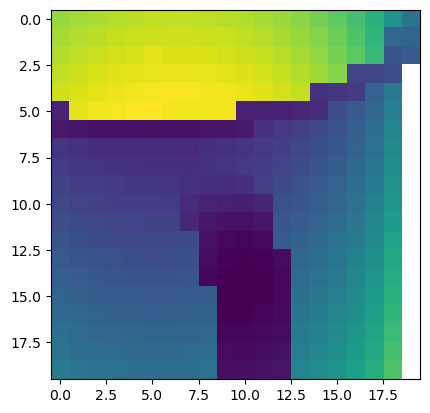

In [42]:
ch = genjax.choice_map({
    "scene": scene_ch,
    "center": jnp.array([90., 70.])
})


key = keysplit(key)
_,tr = model.importance(key, ch, ())

Y = tr.retval

plt.imshow(prep_im(Y))

## Down sampling

In [66]:
from jax._src.image import scale

scale.resize?

Signature:
scale.resize(
    image,
    shape: collections.abc.Sequence[typing.Union[int, typing.Any]],
    method: Union[str, jax._src.image.scale.ResizeMethod],
    antialias: bool = True,
    precision=<Precision.HIGHEST: 2>,
)
Docstring:
Image resize.

The ``method`` argument expects one of the following resize methods:

``ResizeMethod.NEAREST``, ``"nearest"``
  `Nearest neighbor interpolation`_. The values of ``antialias`` and
  ``precision`` are ignored.

``ResizeMethod.LINEAR``, ``"linear"``, ``"bilinear"``, ``"trilinear"``, ``"triangle"``
  `Linear interpolation`_. If ``antialias`` is ``True``, uses a triangular
  filter when downsampling.

``ResizeMethod.CUBIC``, ``"cubic"``, ``"bicubic"``, ``"tricubic"``
  `Cubic interpolation`_, using the Keys cubic kernel.

``ResizeMethod.LANCZOS3``, ``"lanczos3"``
  `Lanczos resampling`_, using a kernel of radius 3.

``ResizeMethod.LANCZOS5``, ``"lanczos5"``
  `Lanczos resampling`_, using a kernel of radius 5.

.. _Nearest neighbor interpo

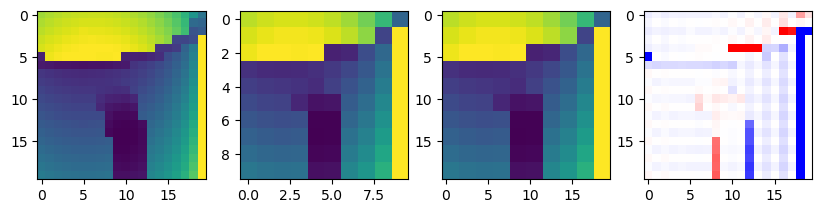

In [64]:
method = ["nearest", "bilinear","trilinear", "triangle", "cubic"][0]

fig, axs = plt.subplots(1,4,figsize=(10,3))
axs[0].imshow(Y[...,2], vmax=1.)

Y_down  = scale.resize(Y[...,2], (10,10), method)
Y_up = scale.resize(Y_down, (20,20), method)
axs[1].imshow(Y_down, vmax=1.)
axs[2].imshow(Y_up, vmax=1.)
axs[3].imshow(Y[...,2] - Y_up, cmap="bwr", vmin=-0.05,vmax=0.05)